In [1]:
import os
import warnings
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.filterwarnings('ignore')

2025-07-15 15:03:20.644601: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752591800.861767      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752591800.923630      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
base_path = "/kaggle/working/face_data"
os.makedirs(os.path.join(base_path, "faces"), exist_ok=True)

# Copy semua file dari folder asli ke subfolder "faces"
original_path = "/kaggle/input/50k-celebrity-faces-image-dataset/Celebrity_Faces_Dataset"
for filename in os.listdir(original_path):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        src = os.path.join(original_path, filename)
        dst = os.path.join(base_path, "faces", filename)
        shutil.copyfile(src, dst)

In [3]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_generator = datagen.flow_from_directory(
    base_path,
    target_size=(64, 64),
    batch_size=128,
    class_mode='input',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    base_path,
    target_size=(64, 64),
    batch_size=128,
    class_mode='input',
    subset='validation'
)

Found 45000 images belonging to 1 classes.
Found 5000 images belonging to 1 classes.


In [4]:
input_img = Input(shape=(64, 64, 3))  # RGB

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)  # 32x32
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)  # 16x16

# Decoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)  # 32x32
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)  # 64x64
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

I0000 00:00:1752592084.669833      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,347 (52.14 KB)

 Trainable params: 13,347 (52.14 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
history = autoencoder.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20
)

Epoch 1/20


I0000 00:00:1752592089.974478      93 service.cc:148] XLA service 0x7f0708045420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752592089.975409      93 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1752592090.472567      93 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/352 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - loss: 0.7008

I0000 00:00:1752592093.765853      93 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


352/352 ━━━━━━━━━━━━━━━━━━━━ 43s 103ms/step - loss: 0.5489 - val_loss: 0.4926
Epoch 2/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 32s 91ms/step - loss: 0.4912 - val_loss: 0.4883
Epoch 3/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 32s 90ms/step - loss: 0.4885 - val_loss: 0.4864
Epoch 4/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 31s 87ms/step - loss: 0.4869 - val_loss: 0.4856
Epoch 5/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 32s 91ms/step - loss: 0.4853 - val_loss: 0.4862
Epoch 6/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step - loss: 0.4850 - val_loss: 0.4843
Epoch 7/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 32s 90ms/step - loss: 0.4851 - val_loss: 0.4842
Epoch 8/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 31s 88ms/step - loss: 0.4844 - val_loss: 0.4836
Epoch 9/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 32s 90ms/step - loss: 0.4840 - val_loss: 0.4833
Epoch 10/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step - loss: 0.4841 - val_loss: 0.4833
Epoch 11/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step - loss: 0.4835 - val_loss: 0.4829
Epoch 12/20
352/352 ━━━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


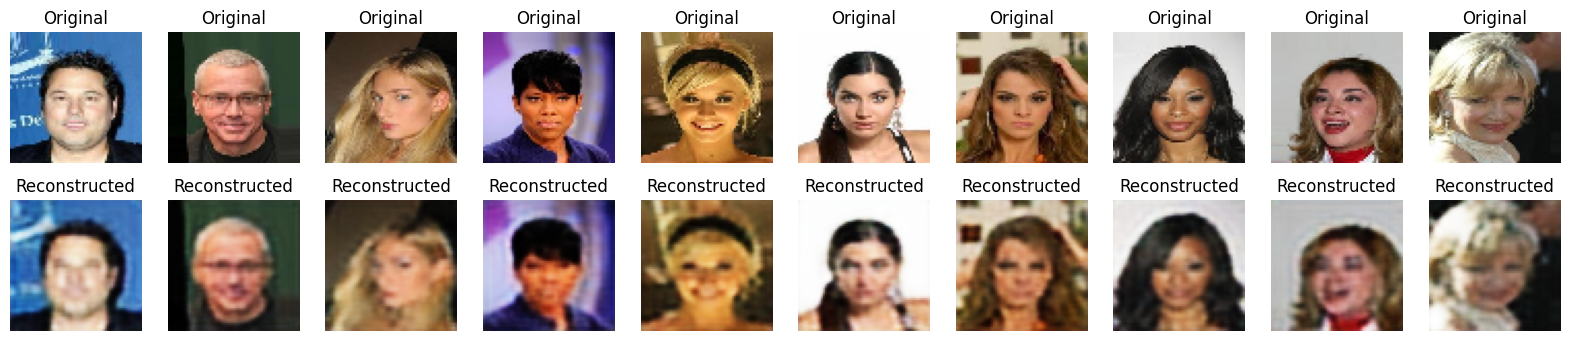

In [6]:
# Ambil sample dari validation set
x_sample, _ = next(val_generator)

# Prediksi hasil rekonstruksi
decoded_imgs = autoencoder.predict(x_sample[:10])

# Tampilkan original vs hasil rekonstruksi
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_sample[i])
    plt.title("Original")
    plt.axis("off")

    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("Reconstructed")
    plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


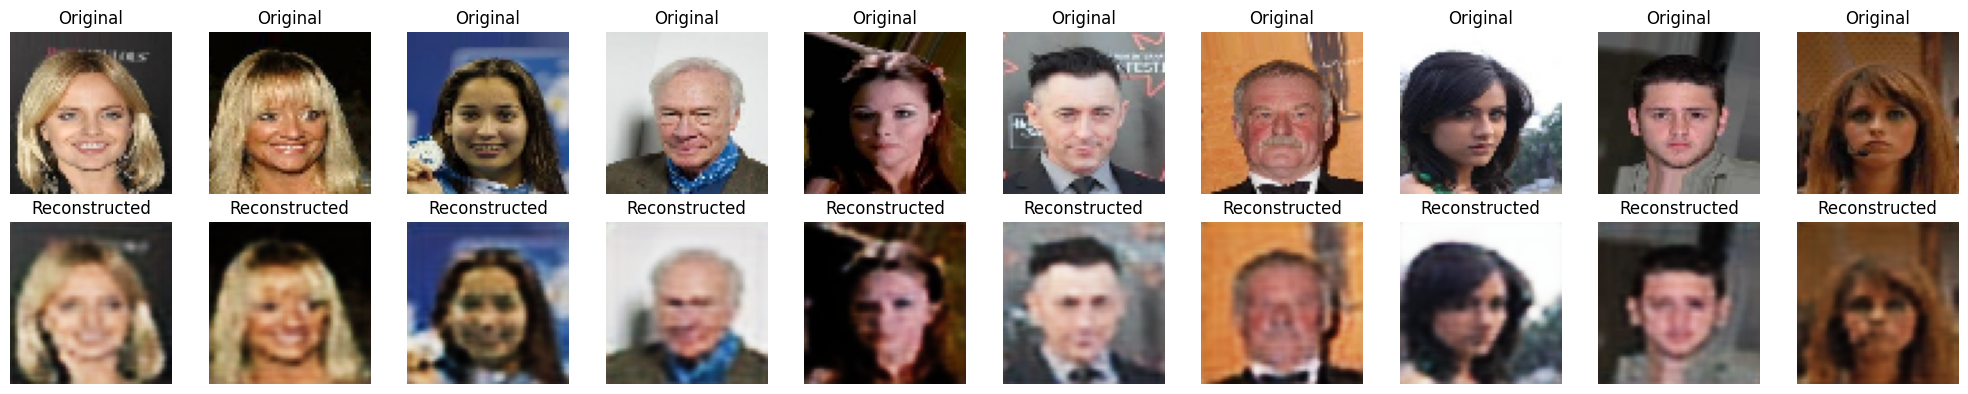

In [8]:
import matplotlib.pyplot as plt

# Ambil 10 gambar dari validation set
x_sample, _ = next(val_generator)

# Lakukan prediksi (rekonstruksi) gambar
decoded_imgs = autoencoder.predict(x_sample[:10])

# Tampilkan hasilnya
n = 10  # jumlah gambar yang mau ditampilkan
plt.figure(figsize=(20, 4))

for i in range(n):
    # Gambar Asli
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_sample[i])
    plt.title("Original")
    plt.axis("off")

    # Gambar Rekonstruksi
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("Reconstructed")
    plt.axis("off")

plt.tight_layout()
plt.show()